In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

/Users/teframartin/EPFL_Cours/MA4/OptiMlForever/.conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


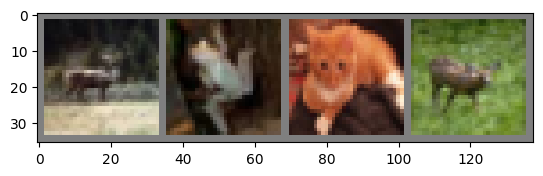

deer  frog  cat   deer 


In [3]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

# Training

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [22]:
def train(net, trainloader, criterion, optimizer, scheduler=None, device='cpu', epochs=2):
    losses = []
    for epoch in range(epochs):  # loop over the dataset multiple times

        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            losses.append(loss.item())
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 2000 == 1999:    # print every 2000 mini-batches
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
                running_loss = 0.0
                
        # Step the scheduler at the end of each epoch if scheduler is provided
        if scheduler is not None:
            scheduler.step()

    print('Finished Training')
    return losses

In [6]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
device = torch.device('cpu')

In [23]:
def train_with_optimizer(optimizer, trainloader, scheduler=None, layer_wise=False, device='cpu'):
    net = Net().to(device)
    net.train()
    if layer_wise:
        optimizer = optimizer([
            {'params': net.conv1.parameters(), 'lr': 0.001},
            {'params': net.conv2.parameters(), 'lr': 0.01},
            {'params': net.fc1.parameters(), 'lr': 0.01},
            {'params': net.fc2.parameters(), 'lr': 0.01},
            {'params': net.fc3.parameters(), 'lr': 0.01}
        ], lr=0.01)
    else:
        optimizer = optimizer(net.parameters(), lr=0.01)
    losses = train(net, trainloader, criterion, optimizer, scheduler=None, device=device)
    return net, losses

### SGD

In [8]:
from optimizers.SignSGD import SignSGD

# SGD
net_sgd, losses_sgd = train_with_optimizer(optim.SGD, trainloader, device=device)
net_sgd_lw, losses_sgd_lw = train_with_optimizer(optim.SGD, trainloader, layer_wise=True, device=device)

# Adam
net_adam, losses_adam = train_with_optimizer(optim.Adam, trainloader, device=device)
net_adam_lw, losses_adam_lw = train_with_optimizer(optim.Adam, trainloader, layer_wise=True, device=device)

# AdaGrad
net_adagrad, losses_adagrad = train_with_optimizer(optim.Adagrad, trainloader, device=device)
net_adagrad_lw, losses_adagrad_lw = train_with_optimizer(optim.Adagrad, trainloader, layer_wise=True, device=device)

# SignSGD
net_signsgd, losses_signsgd = train_with_optimizer(SignSGD, trainloader, device=device)
net_signsgd_lw, losses_signsgd_lw = train_with_optimizer(SignSGD, trainloader, layer_wise=True, device=device)

[1,  2000] loss: 2.056
[1,  4000] loss: 1.749
[1,  6000] loss: 1.670
[1,  8000] loss: 1.614
[1, 10000] loss: 1.579
[1, 12000] loss: 1.556
[2,  2000] loss: 1.508
[2,  4000] loss: 1.497
[2,  6000] loss: 1.492
[2,  8000] loss: 1.493
[2, 10000] loss: 1.480
[2, 12000] loss: 1.503
Finished Training
[1,  2000] loss: 2.038
[1,  4000] loss: 1.755
[1,  6000] loss: 1.656
[1,  8000] loss: 1.598
[1, 10000] loss: 1.578
[1, 12000] loss: 1.568
[2,  2000] loss: 1.516
[2,  4000] loss: 1.498
[2,  6000] loss: 1.542
[2,  8000] loss: 1.506
[2, 10000] loss: 1.512
[2, 12000] loss: 1.516
Finished Training
[1,  2000] loss: 2.331
[1,  4000] loss: 2.318
[1,  6000] loss: 2.577
[1,  8000] loss: 2.318
[1, 10000] loss: 2.319
[1, 12000] loss: 2.318
[2,  2000] loss: 2.315
[2,  4000] loss: 2.318
[2,  6000] loss: 2.316
[2,  8000] loss: 2.320
[2, 10000] loss: 2.317
[2, 12000] loss: 2.318
Finished Training
[1,  2000] loss: 2.332
[1,  4000] loss: 2.318
[1,  6000] loss: 2.317
[1,  8000] loss: 2.318
[1, 10000] loss: 2.317
[1,

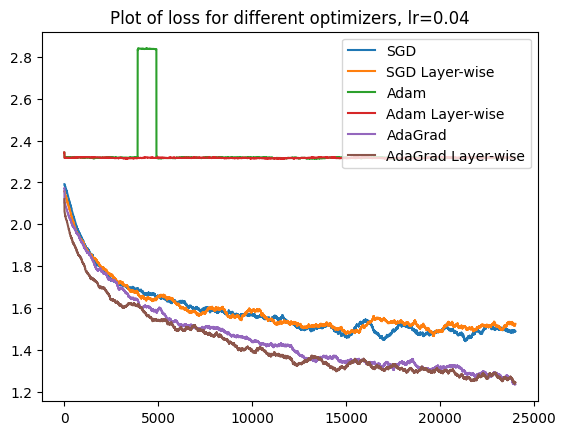

In [10]:
moving_average_sgd = np.convolve(losses_sgd, np.ones(1000)/1000, mode='valid')
moving_average_sgd_lw = np.convolve(losses_sgd_lw, np.ones(1000)/1000, mode='valid')
moving_average_adam = np.convolve(losses_adam, np.ones(1000)/1000, mode='valid')
moving_average_adam_lw = np.convolve(losses_adam_lw, np.ones(1000)/1000, mode='valid')
moving_average_adagrad = np.convolve(losses_adagrad, np.ones(1000)/1000, mode='valid')
moving_average_adagrad_lw = np.convolve(losses_adagrad_lw, np.ones(1000)/1000, mode='valid')

plt.plot(moving_average_sgd, label='SGD')
plt.plot(moving_average_sgd_lw, label='SGD Layer-wise')
plt.plot(moving_average_adam, label='Adam')
plt.plot(moving_average_adam_lw, label='Adam Layer-wise')
plt.plot(moving_average_adagrad, label='AdaGrad')
plt.plot(moving_average_adagrad_lw, label='AdaGrad Layer-wise')
plt.legend()
lr = 0.04
plt.title(f"Plot of loss for different optimizers, lr={lr}")
plt.savefig(f"outputs/optimizer_comparison_{lr}.png")
plt.show()

In [12]:
# trying the other optimizers
from optimizers.Lion import Lion
from optimizers.AdaHessian import Adahessian
# net_lion, losses_lion = train_with_optimizer(Lion, trainloader, device=device)
# net_lion_lw, losses_lion_lw = train_with_optimizer(Lion, trainloader, layer_wise=True, device=device)

# net_adahessian, losses_adahessian = train_with_optimizer(Adahessian, trainloader, device=device)
# net_adahessian_lw, losses_adahessian_lw = train_with_optimizer(Adahessian, trainloader, layer_wise=True, device=device)

[1,  2000] loss: 2.589
[1,  4000] loss: 2.713
[1,  6000] loss: 2.653
[1,  8000] loss: 2.665
[1, 10000] loss: 2.550
[1, 12000] loss: 2.814
[2,  2000] loss: 2.618
[2,  4000] loss: 2.788
[2,  6000] loss: 3.085
[2,  8000] loss: 2.884
[2, 10000] loss: 2.649
[2, 12000] loss: 2.773
Finished Training
[1,  2000] loss: 2.577
[1,  4000] loss: 2.668
[1,  6000] loss: 2.628
[1,  8000] loss: 2.748
[1, 10000] loss: 2.911
[1, 12000] loss: 2.666
[2,  2000] loss: 2.585
[2,  4000] loss: 2.607
[2,  6000] loss: 2.732
[2,  8000] loss: 2.642
[2, 10000] loss: 2.898
[2, 12000] loss: 2.707
Finished Training


- DS -> ≠ optimizers (avec/sans sceduler de base) -> courbe
    => prendre deux optimiser et tester ≠ scheduler 

TODO:

- check for learning rates => do we need to have a specific learning rate for each optimizer or do we use the same one everywhere
- explore scheduler variation during the training => StepLR / CyclicLR / ReduceLROnPlateau / CosineAnnealingLR / LinearLR
- add speed per epoch
- try with an other dataset to compare
- (explore other learning rate schemes)
    1. Time-based Decay
    2. Step Decay
    3. Exponential Decay
    4. Cosine Annealing
    5. Cyclical Learning Rate (CLR)
    6. Warm Restarts (SGDR)
    7. Hyperbolic Tangent Decay
    8. One-cycle Learning Rate
    9. Polynomial Decay

In [21]:
from torch.optim.lr_scheduler import LambdaLR, ReduceLROnPlateau

net = Net()

optimizer = optim.SGD([
            {'params': net.conv1.parameters(), 'lr': 0.001},
            {'params': net.pool.parameters(), 'lr': 0.01},
            {'params': net.conv2.parameters(), 'lr': 0.01},
            {'params': net.fc1.parameters(), 'lr': 0.01},
            {'params': net.fc2.parameters(), 'lr': 0.01},
            {'params': net.fc3.parameters(), 'lr': 0.01}
        ], lr=0.01)

# scheduler = ReduceLROnPlateau(optimizer)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)  # StepLR as an example

net_sgd, losses_sgd = train_with_optimizer(optim.SGD, trainloader, device=device)
net_sgd_stepLR, losses_sgd_stepLR = train_with_optimizer(optim.SGD, trainloader, scheduler, device=device)
net_sgd_lw_stepLR, losses_sgd_lw_stepLR = train_with_optimizer(optim.SGD, trainloader, scheduler, layer_wise=True, device=device)

[1,  2000] loss: 2.024
[1,  4000] loss: 1.739
[1,  6000] loss: 1.658
[1,  8000] loss: 1.617
[1, 10000] loss: 1.570
[1, 12000] loss: 1.547
[2,  2000] loss: 1.484
[2,  4000] loss: 1.502
[2,  6000] loss: 1.495
[2,  8000] loss: 1.486
[2, 10000] loss: 1.487
[2, 12000] loss: 1.487
Finished Training
[1,  2000] loss: 2.037
[1,  4000] loss: 1.732
[1,  6000] loss: 1.666
[1,  8000] loss: 1.617
[1, 10000] loss: 1.561
[1, 12000] loss: 1.545
[2,  2000] loss: 1.520
[2,  4000] loss: 1.485
[2,  6000] loss: 1.490
[2,  8000] loss: 1.499
[2, 10000] loss: 1.496
[2, 12000] loss: 1.487
Finished Training


TypeError: train_with_optimizer() got multiple values for argument 'layer_wise'

In [24]:
net_sgd_lw_stepLR, losses_sgd_lw_stepLR = train_with_optimizer(optim.SGD, trainloader, scheduler, layer_wise=True, device=device)

[1,  2000] loss: 2.193
[1,  4000] loss: 1.889
[1,  6000] loss: 1.717
[1,  8000] loss: 1.613
[1, 10000] loss: 1.551
[1, 12000] loss: 1.486
[2,  2000] loss: 1.423
[2,  4000] loss: 1.398
[2,  6000] loss: 1.370
[2,  8000] loss: 1.347
[2, 10000] loss: 1.319
[2, 12000] loss: 1.288
Finished Training


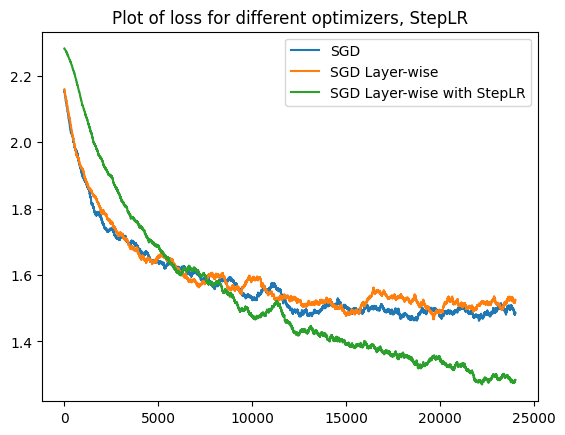

In [27]:
moving_average_sgd = np.convolve(losses_sgd, np.ones(1000)/1000, mode='valid')
moving_average_sgd_lw = np.convolve(losses_sgd_lw, np.ones(1000)/1000, mode='valid')
moving_average_sgd_lw_stepLR = np.convolve(losses_sgd_lw_stepLR, np.ones(1000)/1000, mode='valid')

plt.plot(moving_average_sgd, label='SGD')
plt.plot(moving_average_sgd_lw, label='SGD Layer-wise')
plt.plot(moving_average_sgd_lw_stepLR, label='SGD Layer-wise with StepLR')
plt.legend()
plt.title(f"Plot of loss for different optimizers, StepLR")
plt.savefig(f"outputs/optimizer_comparison_StepLR.png")
plt.show()